In [194]:
!ls '/kaggle/input/shopee-product-images'

data_products_id_small.csv  data_products_id_tiny.csv  images


In [195]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests

from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [196]:
img_root_folder = '/kaggle/input/shopee-product-images/images/download'
text_root_folder = '/kaggle/input/shopee-product-images/'

In [197]:
products = pd.read_csv(f'{text_root_folder}/data_products_id_small.csv')
print(products['sub_category'].value_counts().to_string())
products = products.loc[products['sub_category'] == 'Sandal']

Aksesoris & Perawatan Sepatu                  997
Tote Bag                                      996
Tas Laptop                                    995
Pakaian Dalam                                 994
Sweater & Cardigan                            993
Clutch                                        992
Sandal                                        992
Pakaian Tradisional                           992
Sneakers                                      991
Batik                                         988
Kostum                                        987
Hoodie & Sweatshirt                           985
Jaket, Mantel, & Rompi                        985
Atasan                                        984
Denim                                         980
Set                                           977
Celana Pendek                                 968
Ransel Pria                                   500
Tas Pinggang Pria                             500
Tas Pria Lainnya                              500


In [198]:
def generate_img_path(product_id, image, main_category, sub_category):
    return f"{img_root_folder}/{main_category}/{sub_category}/{image}_tn-{product_id}.jpeg"

products['image_path'] = products.apply(lambda x: generate_img_path(x.product_id, x.image, x.main_category, x.sub_category), axis=1)
products = products.drop(['product_id', 'image', 'shop_name', 'shopid', 'main_category', 'sub_category'], axis=1)

for index, product in tqdm(products.iterrows(), desc='Check Images', total=products.shape[0]):
  if not os.path.exists(product['image_path']):
    print("Not Found")

Check Images:   0%|          | 0/992 [00:00<?, ?it/s]

In [199]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [200]:
products['name'] = products['name'].apply(preprocess)
products.head()

,name,image_path
67988,[start] termurah sandal priasandal silde sanda...,/kaggle/input/shopee-product-images/images/dow...
67989,[start] cod fipper classic original [end],/kaggle/input/shopee-product-images/images/dow...
67990,[start] size 3645 kominsandal hiu couple kartu...,/kaggle/input/shopee-product-images/images/dow...
67991,[start] miniso slippers sandal wanita terbaru ...,/kaggle/input/shopee-product-images/images/dow...
67992,[start] sandal slop karet daily unisex fashion...,/kaggle/input/shopee-product-images/images/dow...


In [201]:
MAX_LENGTH = 128
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 768

In [202]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(products['name'])

In [203]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [204]:
img_to_title_vector = collections.defaultdict(list)
for img, title in zip(products['image_path'], products['name']):
    img_to_title_vector[img].append(title)

img_keys = list(img_to_title_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.95)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], img_keys[slice_index:])

train_imgs = []
train_titles = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_title_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_titles.extend(img_to_title_vector[imgt])

val_imgs = []
val_titles = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_title_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_titles.extend(img_to_title_vector[imgv])

In [205]:
len(train_imgs), len(train_titles), len(val_imgs), len(val_titles)

(942, 942, 50, 50)

In [206]:
def load_data(img_path, title):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(title)
    return img, caption

In [207]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_titles))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_titles))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [208]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [209]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [210]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [211]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [212]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 128, 512])

In [213]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [214]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [215]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [216]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [225]:
history = caption_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/100
30/30 [==============================] - 16s 436ms/step - loss: 5.1116 - acc: 0.1569 - val_loss: 5.5800 - val_acc: 0.1405
Epoch 2/100
30/30 [==============================] - 14s 410ms/step - loss: 5.0707 - acc: 0.1620 - val_loss: 5.5152 - val_acc: 0.1721
Epoch 3/100
30/30 [==============================] - 15s 436ms/step - loss: 4.9933 - acc: 0.1625 - val_loss: 5.3757 - val_acc: 0.1521
Epoch 4/100
30/30 [==============================] - 14s 411ms/step - loss: 4.8986 - acc: 0.1793 - val_loss: 5.3131 - val_acc: 0.1859
Epoch 5/100
30/30 [==============================] - 14s 424ms/step - loss: 4.8623 - acc: 0.1823 - val_loss: 5.4242 - val_acc: 0.1566
Epoch 6/100
30/30 [==============================] - 14s 406ms/step - loss: 4.8224 - acc: 0.1884 - val_loss: 5.4020 - val_acc: 0.1870
Epoch 7/100
30/30 [==============================] - 15s 452ms/step - loss: 4.7785 - acc: 0.1920 - val_loss: 5.3819 - val_acc: 0.1760


In [218]:
idx2word(2).numpy().decode('utf-8')

'sandal'

In [219]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Predicted Caption: sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal sandal sandal sandal sandal sandal sandal pria sandal sandal sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal pria sandal



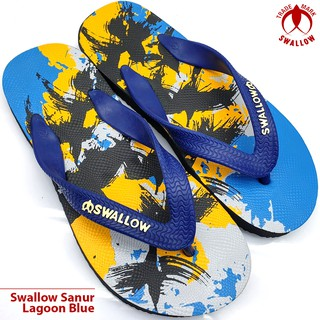

In [230]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)